In [1]:
shifting_factor = 24

# Truncate spectrum function
def truncate_spectrum(wn, spectra, trunc_region=5, wavenumber_shift=5):
    trunc_spectrum = np.copy(spectra)
    trunc_wn = np.copy(wn)

    if wavenumber_shift != 0:
        trunc_spectrum = np.roll(spectra, wavenumber_shift)

    trunc_spectrum = trunc_spectrum[trunc_region:-trunc_region]
    trunc_wn = wn[trunc_region:-trunc_region]

    return trunc_spectrum, trunc_wn

# Function to generate a biased random integer for wavenumber shifting
def biased_random_int():
    return int(np.random.triangular(-shifting_factor, 0, shifting_factor))

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def generate_spectrum(peaks_positions=[200, 450, 750], peaks_widths=[10, 4, 15],
                      peaks_heights=[4000, 2000, 3000], num_baseline_points=5, noise_level=50,
                      baseline_cap = 2000, spectrum_length=900, wavenumber_shift = False):
    """
    Generates a simulated spectrum with given peak parameters, a number of random baseline points, noise level,
    and adjusts for non-negativity. Applies SNV normalization before returning the spectrum.

    Parameters:
    - peaks_positions: List of positions for the peaks.
    - peaks_widths: List of widths for the peaks.
    - peaks_heights: List of heights for the peaks.
    - num_baseline_points: Number of baseline points to generate.
    - noise_level: The standard deviation of the normally distributed noise.
    - baseline_cap: Maximum value for baseline points.
    - spectrum_length: The length of the simulated spectrum.

    Returns:
    - snv_normalized_spectrum: The SNV normalized simulated spectrum as a numpy array.
    """

    if num_baseline_points <= 1:
        raise ValueError("num_baseline_points must be greater than 1 to perform spline interpolation.")

    x_values = np.linspace(0, spectrum_length, spectrum_length)
    peaks = np.zeros_like(x_values)
    for position, width, height in zip(peaks_positions, peaks_widths, peaks_heights):

    # Calculate the scaling factor. Since norm.pdf(x, loc, scale) at x=loc is 1/(sqrt(2*pi)*scale),
    # to get the actual height to match `height`, we multiply by `height` / (1/(sqrt(2*pi)*width)).
      scaling_factor = height / (1 / (np.sqrt(2 * np.pi) * width))
    # Apply the scaling factor to the Gaussian function
      peaks += scaling_factor * norm.pdf(x_values, position, width)

    # Generate noise
    noise = noise_level * np.random.normal(size=x_values.shape)

    #baseline_cap = np.mean(peaks_heights)
    baseline_x = np.linspace(0, max(x_values), num_baseline_points)
    bias_factor = np.linspace(baseline_cap, 0, num_baseline_points)
    baseline_y = np.random.rand(num_baseline_points) * bias_factor

    cs = CubicSpline(baseline_x, baseline_y)
    baseline = cs(x_values)

    simulated_spectrum_spline = peaks + baseline + noise

    # Apply wavenumber shift
    if wavenumber_shift:
      wn_shift = biased_random_int()
      simulated_spectrum_spline,_ = truncate_spectrum(x_values, simulated_spectrum_spline, trunc_region=shifting_factor, wavenumber_shift=wn_shift)

    # Apply SNV normalization
    mean_val = np.mean(simulated_spectrum_spline)
    std_dev = np.std(simulated_spectrum_spline)
    snv_normalized_spectrum = (simulated_spectrum_spline - mean_val) / std_dev

    return snv_normalized_spectrum

In [3]:
# Create a wavenumber axis for plotting purposes
spectrum_length=900
x_values = np.linspace(0, spectrum_length, spectrum_length)
peaks = np.zeros_like(x_values)
_,wavenumbers = truncate_spectrum(x_values, peaks, trunc_region=shifting_factor, wavenumber_shift=5)
wn_length = wavenumbers.shape[0]
wn_length

852

In [6]:
# Function to generate the dataset
def generate_dataset(num_samples_per_class=5000, num_classes=3):
    wn_length = 852  # Example wavenumber length
    spectra = np.zeros((num_samples_per_class * num_classes, wn_length))
    labels = np.zeros(num_samples_per_class * num_classes)

    # Class 0 Parameters
    params_class_0 = {
        "num_baseline_points": 5,
        "peaks_positions": [250, 500, 700],
        "peaks_widths": [10, 4, 15],
        "peaks_heights": [4000, 2000, 3000],
        "noise_level": 150,
        "wavenumber_shift": True
    }

    # Class 1 Parameters
    params_class_1 = {
        "num_baseline_points": 5,
        "peaks_positions": [150, 500, 750],
        "peaks_widths": [10, 4, 15],
        "peaks_heights": [4000, 2000, 3000],
        "noise_level": 150,
        "wavenumber_shift": True
    }

    # Parameters for each class in a list for easier iteration
    class_parameters = [params_class_0, params_class_1]

    # Generate data for class 0 and class 1
    for class_index, params in enumerate(class_parameters):
        start_index = class_index * num_samples_per_class
        end_index = start_index + num_samples_per_class
        for i in range(start_index, end_index):
            spectra[i, :] = generate_spectrum(**params)
            labels[i] = class_index

    # Class 2 Parameters (New Class) for random peaks
    params_class_2_random = {
        "num_baseline_points": 5,
        "peaks_positions": [],  # To be generated randomly
        "peaks_widths": [],
        "peaks_heights": [],
        "noise_level": 150,
        "wavenumber_shift": True
    }

    # Generate data for class 2
    start_index = 2 * num_samples_per_class
    end_index = start_index + num_samples_per_class
    for i in range(start_index, end_index):
        if np.random.rand() < 0.1:  # 10% chance to include one peak from classes 0 or 1
            included_peak = np.random.choice([250, 500, 700, 150, 750])
            params_class_2_random["peaks_positions"] = [included_peak] + list(np.random.randint(100, 800, size=4))
            params_class_2_random["peaks_widths"] = list(np.random.randint(5, 20, size=5))
            params_class_2_random["peaks_heights"] = list(np.random.randint(1000, 5000, size=5))
        else:
            params_class_2_random["peaks_positions"] = list(np.random.randint(100, 800, size=5))
            params_class_2_random["peaks_widths"] = list(np.random.randint(5, 20, size=5))
            params_class_2_random["peaks_heights"] = list(np.random.randint(1000, 5000, size=5))
        spectra[i, :] = generate_spectrum(**params_class_2_random)
        labels[i] = 2

    return spectra, labels

# Example usage
spectra, labels = generate_dataset()

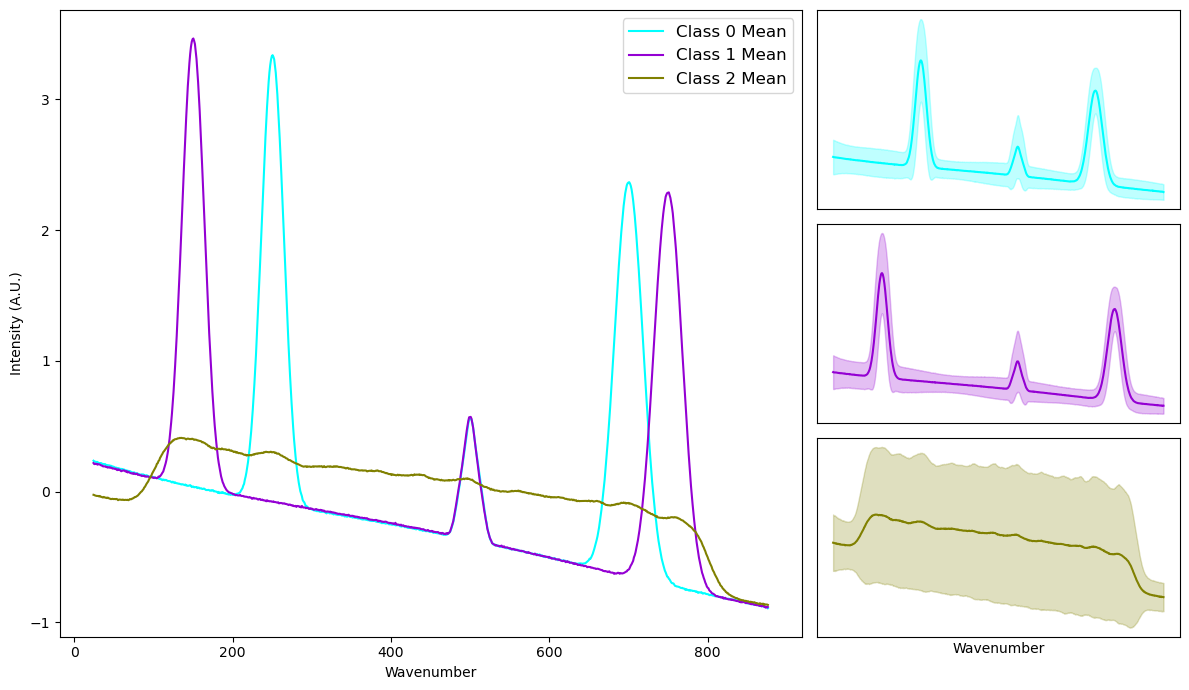

In [7]:
import numpy as np
from matplotlib.gridspec import GridSpec

# Define colors for each class for clarity
colors = ['aqua', 'darkviolet', 'olive']

# Assuming 'spectra' and 'labels' are already generated and contain your simulated data
num_classes = len(np.unique(labels))  # Determine the number of classes

# Create the figure and grid spec based on the number of classes
fig = plt.figure(figsize=(12, 7 + (num_classes - 3)))  # Adjust height for additional rows
gs = GridSpec(nrows=num_classes, ncols=3)

# Main plot for mean spectra
main_ax = fig.add_subplot(gs[:, 0:2])

for class_index in range(num_classes):
    class_spectra = spectra[labels == class_index]
    mean = np.mean(class_spectra, axis=0)
    std = np.std(class_spectra, axis=0)

    # Plotting the mean on the main plot
    main_ax.plot(wavenumbers, mean, label=f'Class {class_index} Mean', color=colors[class_index % len(colors)])

    # Creating smaller std plots for each class
    ax = fig.add_subplot(gs[class_index, 2])
    ax.plot(wavenumbers, mean, color=colors[class_index % len(colors)])
    ax.fill_between(wavenumbers, mean-std, mean+std, alpha=0.25, color=colors[class_index % len(colors)])
    ax.set_xticks([])
    ax.set_yticks([])
    if class_index == num_classes - 1:  # Add x-label on the bottom std plot
        ax.set_xlabel('Wavenumber')

# Finalizing the main plot
main_ax.legend(loc='upper right', prop={'size': 12})
main_ax.set_ylabel('Intensity (A.U.)')
main_ax.set_xlabel('Wavenumber')

plt.tight_layout()
plt.show()

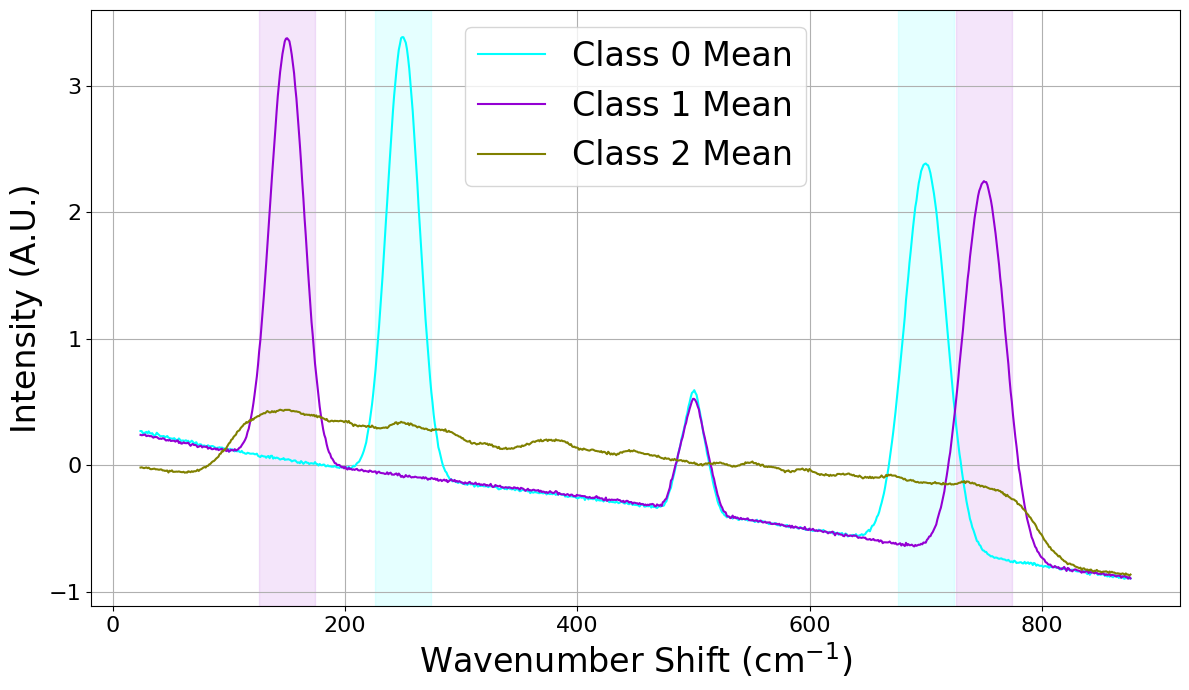

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Coordinates for shading
shaded_coords = [250, 700, 150, 750]
shade_width = 48  # Adjust the width of the shaded area as needed

# Define colors for each class for clarity
colors = ['aqua', 'darkviolet', 'olive']

# Assuming 'spectra', 'labels', and 'wavenumbers' are already generated and contain your simulated data
num_classes = len(np.unique(labels))  # Determine the number of classes

# Store mean and std spectra for later use
mean_spectra = {}
std_spectra = {}

# Create the figure
fig = plt.figure(figsize=(12, 7 + (num_classes - 3)))  # Adjust height for additional rows
main_ax = fig.add_subplot(111)  # Single subplot

for class_index in range(num_classes):
    class_spectra = spectra[labels == class_index]
    mean = np.mean(class_spectra, axis=0)
    std = np.std(class_spectra, axis=0)

    # Storing the mean and std spectra
    mean_spectra[f'Class {class_index} Mean'] = mean
    std_spectra[f'Class {class_index} Std'] = std

    # Plotting the mean on the main plot
    main_ax.plot(wavenumbers, mean, label=f'Class {class_index} Mean', color=colors[class_index % len(colors)])

# Add shaded areas to the main plot with corresponding colors
for i in range(0, len(shaded_coords), 2):
    color_index = (i // 2) % len(colors)
    main_ax.axvspan(shaded_coords[i] - shade_width / 2, shaded_coords[i] + shade_width / 2, color=colors[color_index], alpha=0.1)
    main_ax.axvspan(shaded_coords[i + 1] - shade_width / 2, shaded_coords[i + 1] + shade_width / 2, color=colors[color_index], alpha=0.1)

# Finalizing the main plot
main_ax.legend(loc='best', prop={'size': 24})
main_ax.set_ylabel('Intensity (A.U.)', fontsize=24)
main_ax.set_xlabel('Wavenumber Shift (cm$^{-1}$)', fontsize=24)
# Set the size of the x-tick and y-tick labels
main_ax.tick_params(axis='x', labelsize=16)
main_ax.tick_params(axis='y', labelsize=16)

# Enable grid on the main plot
main_ax.grid(True)

plt.tight_layout()

# Save the figure
save_path = "/content/drive/MyDrive/XAI/Raman XAI/DoublePeakTrainNullMeanSpectra.png"
plt.savefig(save_path, dpi=300)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

X_train, X_val, y_train, y_val = train_test_split(spectra,labels,
                                                  stratify=labels,
                                                  test_size=0.40)

X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,
                                                  stratify=y_val,
                                                  test_size=0.50)

# #Write to Disk
# #Save the data accordingly
for idx in tqdm(range(len(X_train))):
    assert X_train[idx].reshape(1,-1).shape == (1,852)
    np.save(f"Null Dataset/Double Peak/Train/train{idx+1}_class{int(y_train[idx])}.npy",X_train[idx].reshape(1,-1))

for idx in tqdm(range(len(X_test))):
    assert X_test[idx].reshape(1,-1).shape == (1,852)
    np.save(f"Null Dataset/Double Peak/Test/test{idx+1}_class{int(y_test[idx])}.npy",X_test[idx].reshape(1,-1))

for idx in tqdm(range(len(X_val))):
    assert X_val[idx].reshape(1,-1).shape == (1,852)
    np.save(f"Null Dataset/Double Peak/Val/val{idx+1}_class{int(y_val[idx])}.npy",X_val[idx].reshape(1,-1))

100%|██████████| 3000/3000 [00:01<00:00, 1732.64it/s]


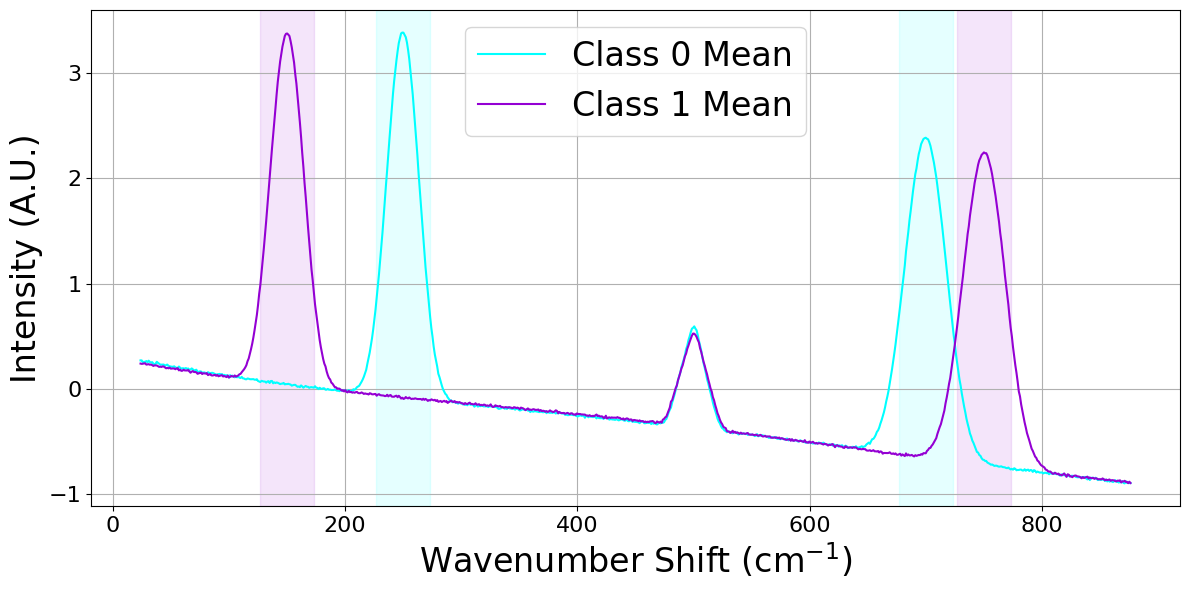

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Coordinates for shading
shaded_coords = [250, 700, 150, 750]
shade_width = 46  # Adjust the width of the shaded area as needed

# Define colors for each class for clarity
colors = ['aqua', 'darkviolet', 'olive']

# Assuming 'spectra', 'labels', and 'wavenumbers' are already generated and contain your simulated data
num_classes = 2  # Limit to the first two classes

# Store mean and std spectra for later use
mean_spectra = {}
std_spectra = {}

# Create the figure
fig = plt.figure(figsize=(12, 7 + (num_classes - 3)))  # Adjust height for additional rows
main_ax = fig.add_subplot(111)  # Single subplot

for class_index in range(num_classes):
    class_spectra = spectra[labels == class_index]
    mean = np.mean(class_spectra, axis=0)
    std = np.std(class_spectra, axis=0)

    # Storing the mean and std spectra
    mean_spectra[f'Class {class_index} Mean'] = mean
    std_spectra[f'Class {class_index} Std'] = std

    # Plotting the mean on the main plot
    main_ax.plot(wavenumbers, mean, label=f'Class {class_index} Mean', color=colors[class_index % len(colors)])

# Add shaded areas to the main plot with corresponding colors
for i in range(0, len(shaded_coords), 2):
    color_index = (i // 2) % len(colors)
    main_ax.axvspan(shaded_coords[i] - shade_width / 2, shaded_coords[i] + shade_width / 2, color=colors[color_index], alpha=0.1)
    main_ax.axvspan(shaded_coords[i + 1] - shade_width / 2, shaded_coords[i + 1] + shade_width / 2, color=colors[color_index], alpha=0.1)

# Finalizing the main plot
main_ax.legend(loc='best', prop={'size': 24})
main_ax.set_ylabel('Intensity (A.U.)', fontsize=24)
main_ax.set_xlabel('Wavenumber Shift (cm$^{-1}$)', fontsize=24)
# Set the size of the x-tick and y-tick labels
main_ax.tick_params(axis='x', labelsize=16)
main_ax.tick_params(axis='y', labelsize=16)

# Enable grid on the main plot
main_ax.grid(True)

plt.tight_layout()

# Save the figure
save_path = "/content/drive/MyDrive/XAI/Raman XAI/DoublePeakTrainNullMeanSpectra.png"
plt.savefig(save_path, dpi=300)
plt.show()

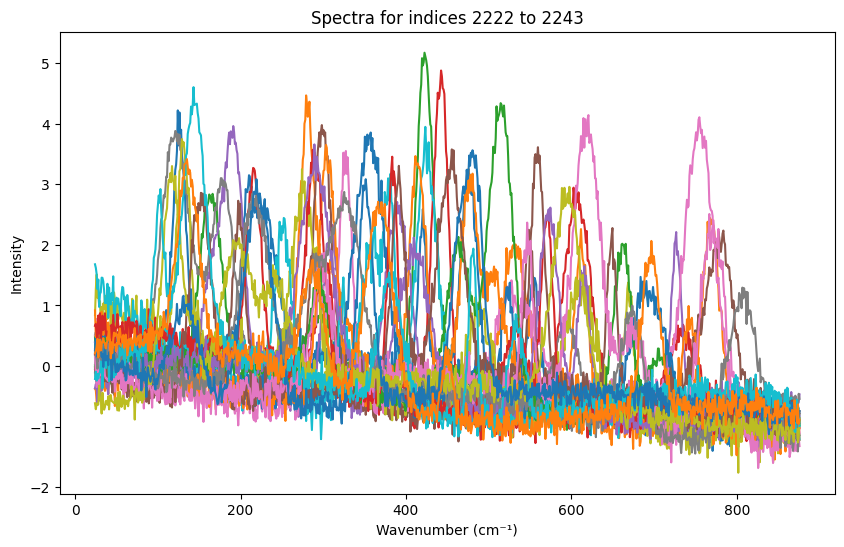

In [ ]:
# Plot multiple spectra
plt.figure(figsize=(10, 6))
for i in range(2222, 2244):
    plt.plot(wavenumbers, spectra[i, :])
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('Spectra for indices 2222 to 2243')
plt.show()

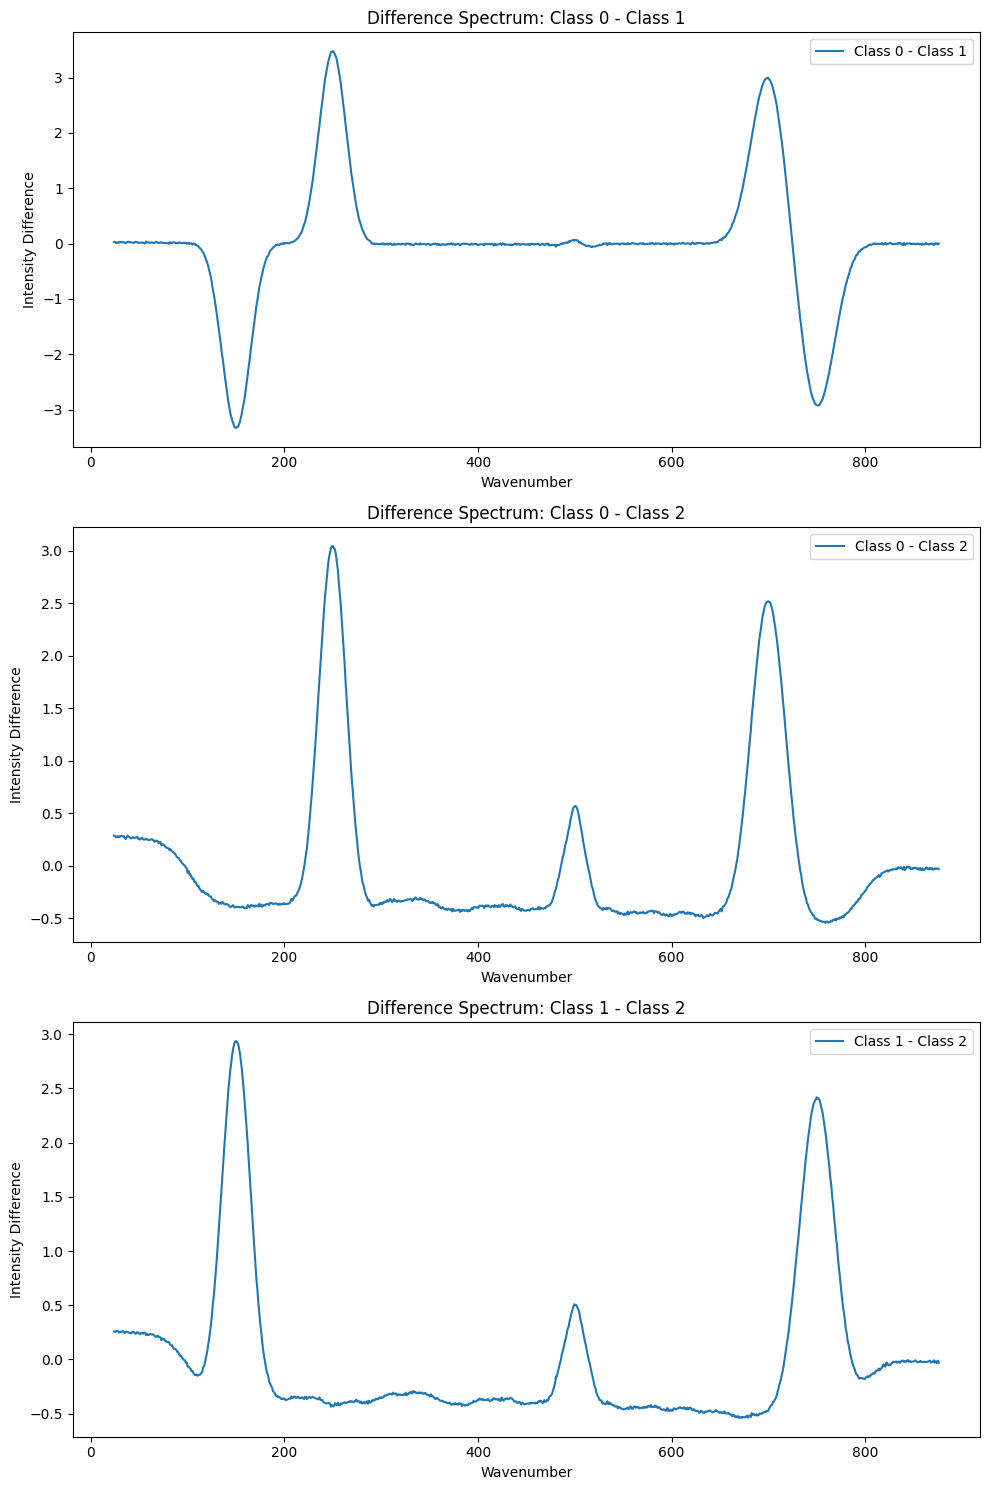

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'spectra' and 'labels' are your dataset and labels respectively
num_classes = len(np.unique(labels))
class_means = []

# Calculate mean spectra for each class
for i in range(num_classes):
    class_spectra = spectra[labels == i]
    class_mean = np.mean(class_spectra, axis=0)
    class_means.append(class_mean)

# Pairwise subtraction to get difference spectra
difference_spectra = []
pair_labels = []

for i in range(num_classes):
    for j in range(i+1, num_classes):
        diff_spectrum = class_means[i] - class_means[j]
        difference_spectra.append(diff_spectrum)
        pair_labels.append(f"Class {i} - Class {j}")

# Assuming 'difference_spectra' and 'pair_labels' are already defined
# as well as 'wavenumbers' for the x-axis

fig, axs = plt.subplots(len(difference_spectra), 1, figsize=(10, 15))

for i, diff_spectrum in enumerate(difference_spectra):
    axs[i].plot(wavenumbers, diff_spectrum, label=pair_labels[i])
    axs[i].set_title(f'Difference Spectrum: {pair_labels[i]}')
    axs[i].set_xlabel('Wavenumber')
    axs[i].set_ylabel('Intensity Difference')
    axs[i].legend()

plt.tight_layout()
plt.show()

# *Define* the CNN and get it on the GPU


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np


class SpectralDataset(Dataset):
    """
    Builds a dataset of spectral data. Use idxs to specify which samples to use
    for dataset - this allows for random splitting into training, validation,
    and test sets. Instead of passing in filenames for X and y, we can also
    pass in numpy arrays directly.
    """
    def __init__(self, X_fn, y_fn, idxs=None, transform=None):
        if type(X_fn) == str:
            self.X = np.load(X_fn)
        else:
            self.X = X_fn
        if type(y_fn) == str:
            self.y = np.load(y_fn)
        else:
            self.y = y_fn
        if idxs is None: idxs = np.arange(len(self.y))
        self.idxs = idxs
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        i = self.idxs[idx]
        x, y = self.X[i], self.y[i]
        x = np.expand_dims(x, axis=0)
        if self.transform:
            x = self.transform(x)
        return (x, y)


### TRANSFORMS ###


class GetInterval(object):
    """
    Gets an interval of each spectrum.
    """
    def __init__(self, min_idx, max_idx):
        self.min_idx = min_idx
        self.max_idx = max_idx

    def __call__(self, x):
        x = x[:,self.min_idx:self.max_idx]
        return x


class ToFloatTensor(object):
    """
    Converts numpy arrays to float Variables in Pytorch.
    """
    def __call__(self, x):
        x = torch.from_numpy(x).float()
        return x


### TRANSFORMS ###


def spectral_dataloader(X_fn, y_fn, idxs=None, batch_size=10, shuffle=True,
    num_workers=4, min_idx=None, max_idx=None, sampler=None):
    """
    Returns a DataLoader with spectral data.
    """
    transform_list = []
    if min_idx is not None and max_idx is not None:
        transform_list.append(GetInterval(min_idx, max_idx))
    transform_list.append(ToFloatTensor())
    transform = transforms.Compose(transform_list)
    dataset = SpectralDataset(X_fn, y_fn, idxs=idxs, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, sampler=sampler)
    return dataloader


def spectral_dataloaders(X_fn, y_fn, n_train=None, p_train=0.8, p_val=0.1,
    n_test=None, batch_size=10, shuffle=True, num_workers=4, min_idx=None,
    max_idx=None):
    """
    Returns train, val, and test DataLoaders by splitting the dataset randomly.
    Can also take X_fn and y_fn as numpy arrays.
    """
    if type(y_fn) == str:
        idxs = np.arange(len(np.load(y_fn)))
    else:
        idxs = np.arange(len(y_fn))
    np.random.shuffle(idxs)
    if n_train is None: n_train = int(p_train * len(idxs))
    n_val = int(p_val * n_train)
    val_idxs, train_idxs = idxs[:n_val], idxs[n_val:n_train]
    if n_test is None: test_idxs = idxs[n_train:]
    else: test_idxs = idxs[n_train:n_train+n_test]
    trainloader = spectral_dataloader(X_fn, y_fn, train_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    valloader = spectral_dataloader(X_fn, y_fn, val_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    testloader = spectral_dataloader(X_fn, y_fn, test_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    return (trainloader, valloader, testloader)

In [ ]:
from torch.autograd import Variable
from torch import nn
import torch
import numpy as np


def run_epoch(epoch, model, dataloader, cuda, training=False, optimizer=None):
    if training:
        model.train()
    else:
        model.eval()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if cuda: inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs), Variable(targets.long())
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        if cuda:
            correct += predicted.eq(targets.data).cpu().sum().item()
        else:
            correct += predicted.eq(targets.data).sum().item()
    acc = 100 * correct / total
    avg_loss = total_loss / total
    return acc, avg_loss


def get_predictions(model, dataloader, cuda, get_probs=False):
    preds = []
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if cuda: inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs), Variable(targets.long())
        outputs = model(inputs)
        if get_probs:
            probs = torch.nn.functional.softmax(outputs, dim=1)
            if cuda: probs = probs.data.cpu().numpy()
            else: probs = probs.data.numpy()
            preds.append(probs)
        else:
            _, predicted = torch.max(outputs.data, 1)
            if cuda: predicted = predicted.cpu()
            preds += list(predicted.numpy().ravel())
    if get_probs:
        return np.vstack(preds)
    else:
        return np.array(preds)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 20, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv1d(20, 40, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm1d(40),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv1d(40, 40, kernel_size=3, stride=1, padding=0), #60
            nn.BatchNorm1d(40), #60
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1))
        #self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(5280, 60) # To get the first number try running the model then when it spits out an error it will give you the shape you need
        self.fc2 = nn.Linear(60, 3)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.2, training=self.training)
        out = self.fc2(out)


        return out

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
# Parameters

batch_size = 256

# Hyperparameters
n_epochs = 60
num_classes = 3
learning_rate = 0.001

# Loss and optimizer
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
cuda = torch.cuda.is_available()

# See model architecture
count_parameters(model)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| layer1.0.weight |    140     |
|  layer1.0.bias  |     20     |
| layer1.1.weight |     20     |
|  layer1.1.bias  |     20     |
| layer2.0.weight |    4000    |
|  layer2.0.bias  |     40     |
| layer2.1.weight |     40     |
|  layer2.1.bias  |     40     |
| layer3.0.weight |    4800    |
|  layer3.0.bias  |     40     |
| layer3.1.weight |     40     |
|  layer3.1.bias  |     40     |
|    fc1.weight   |   316800   |
|     fc1.bias    |     60     |
|    fc2.weight   |    180     |
|     fc2.bias    |     3      |
+-----------------+------------+
Total Trainable Params: 326283


326283

In [ ]:
# Cuda enabled version.

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def train_cnn(model, X_train, y_train, X_test, y_test, learning_rate = 0.0001, beta1 = 0.9, beta2 = 0.999, num_epochs = 30, batch_size = 16, early_stop = 5,weightedLoss = False, learning_curves = True, cuda = False):

    train_loader = spectral_dataloader(X_train,y_train,batch_size = batch_size, shuffle=True) # requires dataloader functions
    test_loader = spectral_dataloader(X_test,y_test,batch_size = batch_size, shuffle=False)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    test_acc_list = []
    test_logloss = []
    test_accuracy = []

            # Loss and optimizer

  #torch.manual_seed(3407) # If we want to fix random seed
    #model = model() #this should be called before running the function so is not needed here
    criterion = nn.CrossEntropyLoss()
    if weightedLoss:
        weight = np.squeeze(get_data_weights(y_train)).to(device) # Need to send all variables used in optimisation to the GPU, including this weights
        criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))
    cuda = torch.cuda.is_available()

    if cuda:
      model.cuda()

    # early stopping set-up
    best_val = 0
    no_improvement = 0
    max_no_improvement = early_stop

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        test_outputs_list = []
        test_predicted_list = []
        test_labels_list = []
        for i, (spectra, labels) in enumerate(train_loader):
            spectra, labels = spectra.cuda(), labels.cuda()
            # Run the forward pass

            outputs = model(spectra)
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.3f}, Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

                # Test the model
        print('Testing epoch {}'.format(epoch + 1))
        model.eval()
        with torch.no_grad():
            test_correct = 0
            test_total = 0
            for test_spectra, test_labels in test_loader:
                test_spectra, test_labels = test_spectra.cuda(), test_labels.cuda()
                test_outputs = model(test_spectra)
                test_outputs_list.append(test_outputs)
                test_labels_list.append(test_labels)
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_predicted_list.append(test_predicted)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()
                acc_te = test_correct / test_total
            test_acc_list.append(acc_te)

            print('Epoch {}: Test Accuracy {} %'.format(epoch+1,(acc_te) * 100))


                # Check performance for early stopping
        if acc_te > best_val or epoch == 0:
            best_val = acc_te
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= max_no_improvement:
            print('Finished early after {} epochs!'.format(epoch+1))
            break

    # Final train score on a single batch
    train_log_loss, train_accuracy, _ = test_a_batch(model ,X_train, y_train, batch_size )

    # Final test score on a single batch
    test_log_loss, test_accuracy, con_mat = test_a_batch(model ,X_test, y_test, batch_size )

    print('Final Training Accuracy {} %'.format((train_accuracy) * 100))
    print('Final Test Accuracy {} %'.format((test_accuracy) * 100))

    if learning_curves:
        plot_learning_curve(acc_list, test_acc_list, epoch)

    return model, con_mat, test_log_loss, test_accuracy, train_log_loss, train_accuracy, test_outputs_list, test_predicted_list

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def test_a_batch(model, X, y, batch_size):
    model.to(device)
    test_loader = spectral_dataloader(X, y, batch_size=batch_size, shuffle=False)

    test_outputs_list = []
    test_predicted_list = []
    test_labels_list = []

    model.eval()
    with torch.no_grad():
        for test_spectra, test_labels in test_loader:
            test_spectra, test_labels = test_spectra.to(device), test_labels.to(device)

            test_outputs = model(test_spectra)
            _, test_predicted = torch.max(test_outputs.data, 1)

            test_outputs_list.append(test_outputs)
            test_predicted_list.append(test_predicted)
            test_labels_list.append(test_labels)

    # Convert lists of tensors to a single tensor
    test_outputs_tensor = torch.cat(test_outputs_list, dim=0)
    test_labels_tensor = torch.cat(test_labels_list, dim=0)
    test_predicted_tensor = torch.cat(test_predicted_list, dim=0)

    # Now you can detach and move to CPU
    test_outputs_np = test_outputs_tensor.detach().cpu().numpy()
    test_labels_np = test_labels_tensor.detach().cpu().numpy()
    test_predicted_np = test_predicted_tensor.detach().cpu().numpy()

    # Calculate metrics
    test_log_loss = metrics.log_loss(test_labels_np, test_outputs_np, labels=np.unique(y))
    test_accuracy = metrics.accuracy_score(test_labels_np, test_predicted_np)
    con_mat = confusion_matrix(test_labels_np, test_predicted_np)

    return test_log_loss, test_accuracy, con_mat

In [ ]:
# 5x3 CV on all data. No hyperparameter search

from sklearn import metrics
from sklearn.model_selection import KFold

n_repeats = 5
folds = 3

outer_accuracy = []
outer_log_loss = []
outer_conmat = []

counter = 0
while counter < n_repeats*folds:
    # Initialize KFold
    kf = KFold(n_splits=folds, shuffle=True)
    for train_index, test_index in kf.split(spectra, labels):

        X_train, X_test = spectra[train_index], spectra[test_index]
        y_train, y_test = labels[train_index], labels[test_index]


        # perform CNN on the train and test data
        convnet, con_mat, test_ll, test_acc, train_ll, train_acc, test_outputs, test_predicted  = train_cnn(model, X_train, y_train, X_test, y_test, learning_rate = learning_rate, num_epochs = n_epochs, batch_size = batch_size, early_stop = 3, weightedLoss = False, learning_curves = False)

        outer_accuracy.append(test_acc)
        outer_log_loss.append(test_ll)
        outer_conmat.append(con_mat)

        counter = counter+1
print("accuracy: {} +/- {}".format(np.mean(outer_accuracy),np.std(outer_accuracy)))

Testing epoch 1
Epoch 1: Test Accuracy 32.5 %
Testing epoch 2
Epoch 2: Test Accuracy 32.5 %
Testing epoch 3
Epoch 3: Test Accuracy 32.5 %
Testing epoch 4
Epoch 4: Test Accuracy 32.5 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 33.75 %
Final Test Accuracy 32.5 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 94.0 %
Testing epoch 2
Epoch 2: Test Accuracy 98.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Testing epoch 5
Epoch 5: Test Accuracy 100.0 %
Testing epoch 6
Epoch 6: Test Accuracy 100.0 %
Finished early after 6 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 99.9 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 99.9 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 99.3 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Testing epoch 5
Epoch 5: Test Accuracy 100.0 %
Finished early after 5 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 99.9 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 99.65 %
Final Test Accuracy 99.9 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 99.9 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 99.9 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 99.9 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 99.9 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 100.0 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 100.0 %
Final Test Accuracy 100.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Testing epoch 1
Epoch 1: Test Accuracy 100.0 %
Testing epoch 2
Epoch 2: Test Accuracy 100.0 %
Testing epoch 3
Epoch 3: Test Accuracy 100.0 %
Testing epoch 4
Epoch 4: Test Accuracy 99.9 %
Finished early after 4 epochs!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Final Training Accuracy 99.95 %
Final Test Accuracy 99.9 %
accuracy: 0.9548000000000001 +/- 0.1683215969505993


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    else:
      thresh = cm.min()+(cm.max() - cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

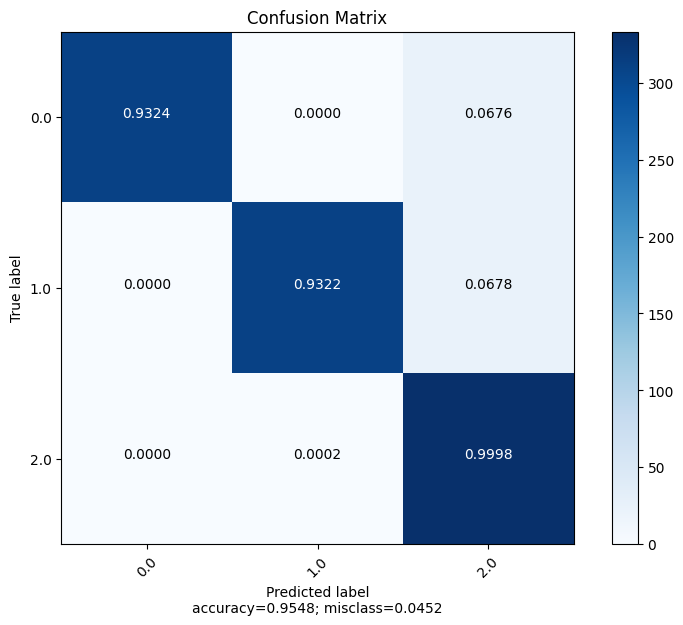

In [ ]:
plot_confusion_matrix(cm=np.mean(outer_conmat, axis=0),
                      target_names=np.unique(labels),
                      title='Confusion Matrix',
                      normalize=True)
plt.show()

In [ ]:
    # Train on the entire dataset

    num_epochs = 3
    train_loader = spectral_dataloader(spectra,labels,batch_size = batch_size, shuffle=True)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        test_outputs_list = []
        test_predicted_list = []
        test_labels_list = []
        for i, (spec, labs) in enumerate(train_loader):
            spec, labs = spec.cuda(), labs.cuda()
            # Run the forward pass

            outputs = model(spec)
            loss = criterion(outputs, labs.long())
            #loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
pip install ONNX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 67.6 MB/s eta 0:00:00


In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), "/content/drive/MyDrive/XAI/Raman XAI/double_peak_NULL_model_PT.")

In [ ]:
import torch

# Function to export the model
def export_model_to_onnx(model, dummy_input, output_path="/content/drive/MyDrive/XAI/Raman XAI/double_peak_NULL_model.onnx"):
    model.eval()  # Set the model to evaluation mode
    torch.onnx.export(model,
                      dummy_input,
                      output_path,
                      export_params=True,
                      opset_version=12,  # Use a higher opset version if possible
                      do_constant_folding=True,  # Enable constant folding for optimization
                      input_names=['input'],
                      output_names=['output'],
                      training=torch.onnx.TrainingMode.EVAL)  # Ensure model is exported in evaluation mode

# Initialize and move the model to GPU (if CUDA is available)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = ConvNet().to(device)

# Create dummy input with the shape (batch_size, channels, length)
# Assuming the input length as wn_length for demonstration purposes
dummy_input = torch.randn(1, 1, wn_length).to(device)  # Move the dummy input to the same device as the model

# Export the model
export_model_to_onnx(model, dummy_input)

print("Model has been successfully exported to ONNX format.")

Model has been successfully exported to ONNX format.


In [ ]:
# Generate the dataset with three classes
test_spectra, test_labels = generate_dataset(num_samples_per_class=1000)

# Verifying the dataset's structure for three classes
print("Spectra shape:", test_spectra.shape)
print("Labels shape:", test_labels.shape)

Spectra shape: (3000, 852)
Labels shape: (3000,)


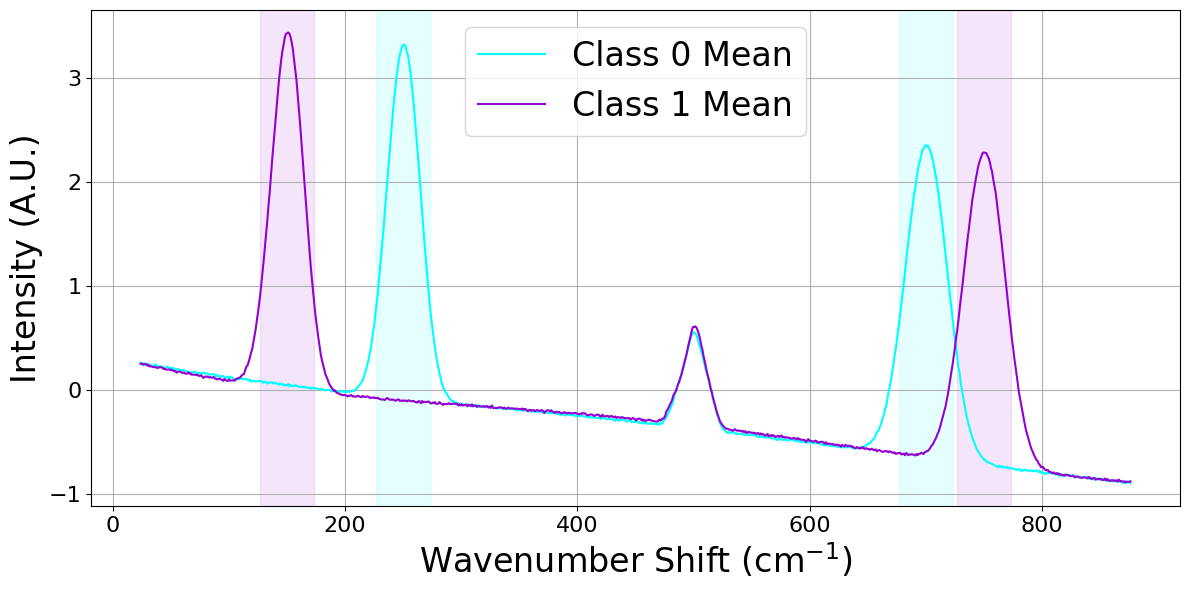

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Coordinates for shading
shaded_coords = [250, 700, 150, 750]
shade_width = 46  # Adjust the width of the shaded area as needed

# Define colors for each class for clarity
colors = ['aqua', 'darkviolet', 'olive']

# Assuming 'spectra', 'labels', and 'wavenumbers' are already generated and contain your simulated data
num_classes = 2  # Limit to the first two classes

# Store mean and std spectra for later use
mean_spectra = {}
std_spectra = {}

# Create the figure
fig = plt.figure(figsize=(12, 7 + (num_classes - 3)))  # Adjust height for additional rows
main_ax = fig.add_subplot(111)  # Single subplot

for class_index in range(num_classes):
    class_spectra = test_spectra[test_labels == class_index]
    mean = np.mean(class_spectra, axis=0)
    std = np.std(class_spectra, axis=0)

    # Storing the mean and std spectra
    mean_spectra[f'Class {class_index} Mean'] = mean
    std_spectra[f'Class {class_index} Std'] = std

    # Plotting the mean on the main plot
    main_ax.plot(wavenumbers, mean, label=f'Class {class_index} Mean', color=colors[class_index % len(colors)])

# Add shaded areas to the main plot with corresponding colors
for i in range(0, len(shaded_coords), 2):
    color_index = (i // 2) % len(colors)
    main_ax.axvspan(shaded_coords[i] - shade_width / 2, shaded_coords[i] + shade_width / 2, color=colors[color_index], alpha=0.1)
    main_ax.axvspan(shaded_coords[i + 1] - shade_width / 2, shaded_coords[i + 1] + shade_width / 2, color=colors[color_index], alpha=0.1)

# Finalizing the main plot
main_ax.legend(loc='best', prop={'size': 24})
main_ax.set_ylabel('Intensity (A.U.)', fontsize=24)
main_ax.set_xlabel('Wavenumber Shift (cm$^{-1}$)', fontsize=24)
# Set the size of the x-tick and y-tick labels
main_ax.tick_params(axis='x', labelsize=16)
main_ax.tick_params(axis='y', labelsize=16)

# Enable grid on the main plot
main_ax.grid(True)

plt.tight_layout()

# Save the figure
save_path = "/content/drive/MyDrive/XAI/Raman XAI/DoublePeakTestNullMeanSpectra.png"
plt.savefig(save_path, dpi=300)
plt.show()

In [ ]:
import os

# Define the save directory
save_dir = '/content/drive/MyDrive/XAI/Raman XAI/'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save each array using the appropriate class name
for key, array in mean_spectra.items():
    class_number = key.split()[1]  # Extract class number from the key
    filename = f'{save_dir}DoublePeakNULLClass_{class_number} Mean.npy'
    np.save(filename, array)
    print(f'Saved: {filename}')

Saved: /content/drive/MyDrive/XAI/Raman XAI/DoublePeakNULLClass_0 Mean.npy
Saved: /content/drive/MyDrive/XAI/Raman XAI/DoublePeakNULLClass_1 Mean.npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
n_components = 10  # Number of principal components to keep
pca = PCA(n_components=n_components)
pca_scores = pca.fit_transform(test_spectra)

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(wavenumbers, pca.components_[i], label=f'PC{i+1}')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('First 10 Principal Component Loadings')
plt.legend()
plt.show()

# Plotting the score plots for the first 6 PCs
labels_unique = np.unique(test_labels)
pairs = [(i, j) for i in range(6) for j in range(i + 1, 6)]  # All unique pairs of the first 6 PCs

plt.figure(figsize=(20, 20))
for i, (pc1, pc2) in enumerate(pairs):
    plt.subplot(5, 3, i + 1)
    for label in labels_unique:
        idx = test_labels == label
        plt.scatter(pca_scores[idx, pc1], pca_scores[idx, pc2], label=f'Class {label}', alpha=0.6)
    plt.xlabel(f'PC{pc1 + 1}')
    plt.ylabel(f'PC{pc2 + 1}')
    plt.title(f'Score Plot PC{pc1 + 1} vs PC{pc2 + 1}')
    if i == 0:  # Only add legend to the first subplot to avoid clutter
        plt.legend()
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.